# __05 Model Evaluation and Improvement__

To evaluate our supervised models, so far we have split our dataset into a training set
and a test set using the `train_test_split` function, built a model on the training set
by calling the fit method, and evaluated it on the test set using the score method,
which for classification computes the fraction of correctly classified samples. Here’s
an example of that process:

In [22]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state = 0)

# split data nad labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# evaluate the model in the test set
print(f'test set score: {logreg.score(X_test, y_test):.2f}')

test set score: 0.88


In this chapter, we will expand on two aspects of this evaluation. We will first intro‐
duce cross-validation, a more robust way to assess generalization performance, and
discuss methods to evaluate classification and regression performance that go beyond
the default measures of accuracy and $R^2$ provided by the score method.

## __Cross Validation__

_Cross-Validation_ is a statistical method of evaluating generalization
performance that is more stable and thorough than using a split into
a training and a test set. I cross-validation, the data is instead split
repeatedly and multiple models are trained.

The most commonly used version of cross-validation is __k-fold cross validation__, where _k_
is a user specified number. When performing _k-fold cross validation_, the data is first
partitioned into _k_ parts of (approximately) equal size, called _folds_.
Next, a sequence of models is trained. The first mdoel is trained using the first
fold as the test set, and the remaining folds 2-_k_ are used as the training set.

The model is built using the data in folds 2–k, and then the accuracy is evaluated on fold 1. Then
another model is built, this time using fold 2 as the test set and the data in folds 1, 3,
4, ..., _k_ as the training set. This process is repeated using folds 3, 4, ...,  _k_ as test sets.
For each of these five splits of the data into training and test sets, we compute the
accuracy. In the end, we have collected _k_ accuracy values.

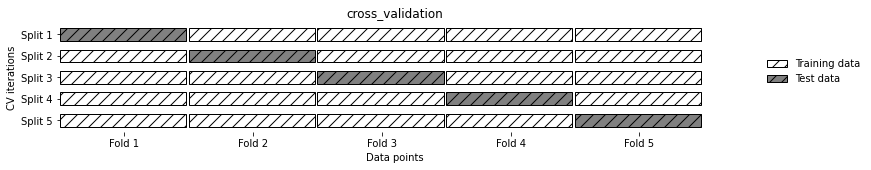

In [23]:
import mglearn
mglearn.plots.plot_cross_validation()

In [24]:
# prettu print numpy floats
import numpy as np
np.set_printoptions(precision = 3)

In [25]:
# applying cross-validation in scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter = 9000)

scores = cross_val_score(logreg, iris.data, iris.target)
print(f'cross-validation scores: {scores}')

cross-validation scores: [0.967 1.    0.933 0.967 1.   ]


In [26]:
# averag cross validation
print(f'average cross-validation score: {scores.mean():.3f}')

average cross-validation score: 0.973


Using the mean cross-validation we can conclude that we expect the model to be
around 96% accurate on average. Looking at all five scores produced by the five-fold
cross-validation, we can also conclude that there is a relatively high variance in the
accuracy between folds, ranging from 100% accuracy to 90% accuracy. This could
imply that the model is very dependent on the particular folds used for training, but it
could also just be a consequence of the small size of the dataset.

There are several benefits to using cross-validation instead of a single split into a
training and a test set. First, remember that train_test_split performs a random
split of the data. Imagine that we are “lucky” when randomly splitting the data, and
all examples that are hard to classify end up in the training set. In that case, the test
set will only contain “easy” examples, and our test set accuracy will be unrealistically
high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-
classify examples in the test set and consequently obtain an unrealistically low score.
However, when using cross-validation, each example will be in the training set exactly
once: each example is in one of the folds, and each fold is the test set once. Therefore,
the model needs to generalize well to all of the samples in the dataset for all of the
cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensi‐
tive our model is to the selection of the training dataset. For the iris dataset, we saw
accuracies between 90% and 100%. This is quite a range, and it provides us with an
idea about how the model might perform in the worst case and best case scenarios
when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is
that we use our data more effectively. When using train_test_split , we usually use
75% of the data for training and 25% of the data for evaluation. When using five-fold
cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the
model. When using 10-fold cross-validation, we can use nine-tenths of the data
(90%) to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are
now training k models instead of a single model, cross-validation will be roughly k
times slower than doing a single split of the data.

## Stratified k-Fold Cross-Validation and Other Strategies

scikit-learn does not use vanilla k-fold crossvalidation for classifica‐
tion, but rather uses stratified k-fold cross-validation. In stratified cross-validation, we
split the data such that the proportions between classes are the same in each fold as
they are in the whole dataset.

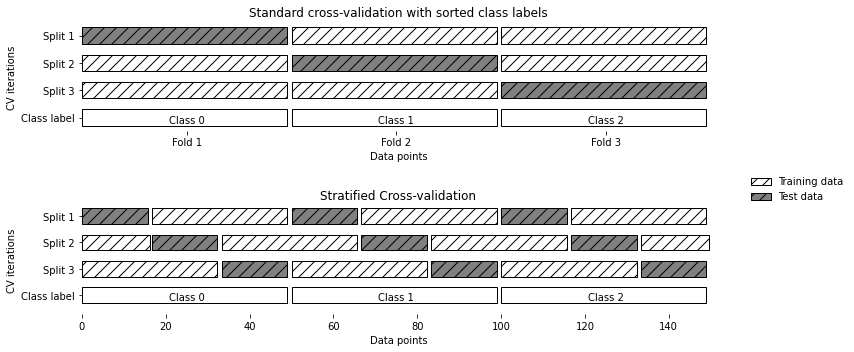

In [27]:
mglearn.plots.plot_stratified_cross_validation()

It is usually a good idea to use stratified k-fold cross-validation instead of k-fold
cross-validation to evaluate a classifier, because it results in more reliable estimates of
generalization performance. In the case of only 10% of samples belonging to class B,
using standard k-fold cross-validation it might easily happen that one fold only con‐
tains samples of class A. Using this fold as a test set would not be very informative
about the overall performance of the classifier.

For regression, scikit-learn uses the standard k-fold cross-validation by default. It
would be possible to also try to make each fold representative of the different values
the regression target has, but this is not a commonly used strategy and would be sur‐
prising to most users.

#### More control over cross-validation

We saw earlier that we can adjust the number of folds that are used in
cross_val_score using the cv parameter. However, scikit-learn allows for much
finer control over what happens during the splitting of the data by providing a cross-
validation splitter as the cv parameter. For most use cases, the defaults of k-fold cross-
validation for regression and stratified k-fold for classification work well, but there
are some cases where you might want to use a different strategy. Say, for example, we
want to use the standard k-fold cross-validation on a classification dataset to repro‐
duce someone else’s results. To do this, we first have to import the KFold splitter class
from the model_selection module and instantiate it with the number of folds we
want to use:

In [28]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 3)
print(f'cross validation scores: {cross_val_score(logreg, iris.data, iris.target, cv = kfold)}')

cross validation scores: [0. 0. 0.]


This way, we can verify that it is indeed a really bad idea to use three-fold (nonstrati‐
fied) cross-validation on the iris dataset.

In [29]:
# shuffle data in Kfold
kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)
print('cross-validation scores: ', cross_val_score(logreg, iris.data, iris.target, cv = kfold))

cross-validation scores:  [0.98 0.96 0.96]


Another frequently used cross-validation method is __leave-one-out__. You can think of
leave-one-out cross-validation as k-fold cross-validation where each fold is a single
sample. For each split, you pick a single data point to be the test set. This can be very
time consuming, particularly for large datasets, but sometimes provides better estimates on small datasets:

In [30]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv = loo)
print('number of cv iterations: ', len(scores))
print(f'mean accuracy: {scores.mean():.3f}')

number of cv iterations:  150
mean accuracy: 0.967


### Shuffle-Split Cross-Validation

Another, very flexible strategy for cross-validation is shuffle-split cross-validation. In
shuffle-split cross-validation, each split samples `train_size` many points for the
training set and `test_size` many (disjoint) point for the test set. This splitting is
repeated `n_iter` times.

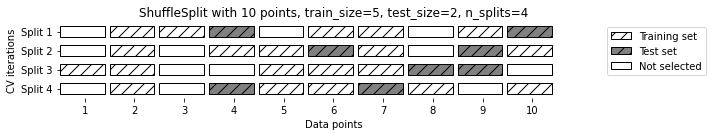

In [31]:
mglearn.plots.plot_shuffle_split()

In [32]:
# split dataset into 50% training set
# and 50% test set for 10 iterations
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size = 0.5, train_size = 0.5, n_splits = 10)
scores = cross_val_score(logreg, iris.data, iris.target, cv = shuffle_split)
print(f'cross-validation scores: {scores}')

cross-validation scores: [0.947 0.933 0.96  0.933 0.973 0.973 0.973 0.96  0.973 0.947]


Shuffle-split cross-validation allows for control over the number of iterations inde‐
pendently of the training and test sizes, which can sometimes be helpful. It also allows
for using only part of the data in each iteration, by providing `train_size` and
`test_size` settings that don’t add up to one. Subsampling the data in this way can be
useful for experimenting with large datasets.

### __Cross-Validation with groups__

Another very common setting for cross-validation is when there are groups in the
data that are highly related. Say you want to build a system to recognize emotions
from pictures of faces, and you collect a dataset of pictures of 100 people where each
person is captured multiple times, showing various emotions. The goal is to build a
classifier that can correctly identify emotions of people not in the dataset. You could
use the default stratified cross-validation to measure the performance of a classifier
here. However, it is likely that pictures of the same person will be in both the training
and the test set. It will be much easier for a classifier to detect emotions in a face that
is part of the training set, compared to a completely new face. To accurately evaluate
the generalization to new faces, we must therefore ensure that the training and test
sets contain images of different people.

To achieve this, we can use `GroupKFold`, which takes an array of groups ar argument that we can use to
indicate which person is in the image. The `groups` array here indicates groups in the data
that should not be split whenc reating the training ant test sets, and should no be
confused with the class label.

This example of groups in the data is common in medical applications, where you
might have multiple samples from the same patient, but are interested in generalizing
to new patients. Similarly, in speech recognition, you might have multiple recordings
of the same speaker in your dataset, but are interested in recognizing speech of new
speakers.

The following is an example of using a synthetic dataset with a grouping given by the
groups array. The dataset consists of 12 data points, and for each of the data points,
groups specifies which group (think patient) the point belongs to. The groups specify
that there are four groups, and the first three samples belong to the first group, the
next four samples belong to the second group, and so on:

In [33]:
from sklearn.model_selection import GroupKFold

# create synthetic dataset
X, y = make_blobs(n_samples = 12, random_state = 0)

# assume the first three samples belong to the same group
# then the next four, etc
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv = GroupKFold(n_splits = 3))
print('cross validation scores: ', scores)

cross validation scores:  [0.75  0.6   0.667]


As you can see, for each split, each group is either entirely in the training set or
entirely in the test set:

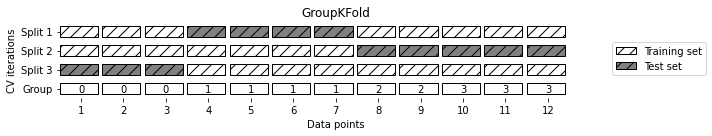

In [34]:
mglearn.plots.plot_group_kfold()

## __Grid Search__

Now that we know how to evaluate how well a model generalizes, we can take the
next step and improve the model’s generalization performance by tuning its parame‐
ters.
Finding the values of the important parameters of a
model (the ones that provide the best generalization performance) is a tricky task, but
necessary for almost all models and datasets. Because it is such a common task, there
are standard methods in scikit-learn to help you with it. The most commonly used
method is grid search, which basically means trying all possible combinations of the
parameters of interest.


### __Simple Grid Search__

We can implement a simple grid search just as `for` loops over the two parameters,
training and evaluating a classifeir for each combination:


In [35]:
# naive grid search implementation
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

print(f'shape of training set: {X_train.shape}', end = '   |   ')
print(f'shape of test set: {X_test.shape}')

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        
        #evaluate the SVC in the test set
        score = svm.score(X_test, y_test)
        
        #if we got a better score, store the score and params
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
    
print(f'best score: {best_score:.2f}')
print(f'best parameters: {best_parameters}')

shape of training set: (112, 4)   |   shape of test set: (38, 4)
best score: 0.97
best parameters: {'C': 100, 'gamma': 0.001}


### __The Danger of Overfitting the Parameters and Validation Set__

Given this resutl, we might be tempted to report that we dounf a model that
performs 97% accuracy on out dataset. However, this claom could be overly
optimistic (or just wrong), for thr following reason: we tried many
different parameters and selected the one with best accuracy on the test set, but
this accuracy won't necessarily carry over to new data. Because we used the test data
to adjust the parameters, we can no longer use it to asses how good the model is.
This is the same reason we needed to split the data into training and test
sets int he first place; we need an independent dataset to evaluateç, one that
was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the
training set to build the model, the validation (or development) set to select the
parameters of the model, and the test set to evaluate the performance of the selected
parameters.

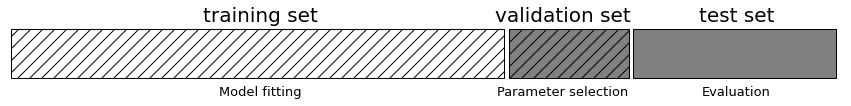

In [36]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a 
model using the parameter serings we found, but now training on both the training data
and the validation data. This way, we can use as mich data as possible
to build our model.


In [37]:
# implementation of the addition of validation set
from sklearn.svm import SVC

# split data into train + validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

# split train + validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state = 1
)

print(f'shape of training set: {X_train.shape}', end = '  |  ')
print(f'shape of validation set: {X_valid.shape}', end = '  |  ')
print(f'shape of test set: {X_test.shape}')


best_score = 0
model_parameters = [0.001, 0.001, 0.1, 1, 10, 100]
for gamma in model_parameters:
    for C in model_parameters:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model in the combined training and validation set
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)

print(f"Best score on validation set: {best_score:.2f}")
print("Best parameters: ", best_parameters)
print(f"Test set score with best parameters: {test_score:.2f}")

shape of training set: (84, 4)  |  shape of validation set: (28, 4)  |  shape of test set: (38, 4)
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably
because we used less data to train the model ( X_train is smaller now because we split
our dataset twice). However, the score on the test set—the score that actually tells us
how well we generalize—is even lower, at 92%. So we can only claim to classify new
data 92% correctly, not 97% correctly as we thought before.

The distinction between the training set, validation set, and test set is fundamentally
important to applying machine learning methods in practice. Any choices made
based on the test set accuracy “leak” information from the test set into the model.
Therefore, it is important to keep a separate test set, which is only used for the final
evaluation. It is good practice to do all exploratory analysis and model selection using
the combination of a training and a validation set, and reserve the test set for a final
evaluation—this is even true for exploratory visualization. Strictly speaking, evaluat‐
ing more than one model on the test set and choosing the better of the two will result
in an overly optimistic estimate of how accurate the model is.

## __Grid Search with Cross-Valdiation__

While the method of splitting the data into a training, a validation, and a test set
that we just saw is workable, and relatively commonly used, it is quite sensitive to
how exactly the data is split.

For a better estimate of the generalziation performance, isntead of using
a single split into a training and a validation set, we can use cross-validation to
evaluate the performance of each parameter combination.

In [49]:
# implementation of the addition of validation set
from sklearn.svm import SVC

# split data into train + validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

print(f'shape of train-validation set: {X_trainval.shape}', end = '  |  ')
print(f'shape of test set: {X_test.shape}')


best_score = 0
model_parameters = [0.001, 0.01, 0.1, 1, 10, 100]
for gamma in model_parameters:
    for C in model_parameters:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv = 5)
        
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model in the combined training and validation set
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)

print(f"Best score on validation set: {best_score:.2f}")
print("Best parameters: ", best_parameters)
print(f"Test set score with best parameters: {test_score:.2f}")

shape of train-validation set: (112, 4)  |  shape of test set: (38, 4)
Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


For each parameter setting (only a subset is shown), five accuracy values are compu‐
ted, one for each split in the cross-validation. Then the mean validation accuracy is
computed for each parameter setting.

The overall process of splitting the data, running the grid srach
and evaluating final parametes is depcited in the next diagram:

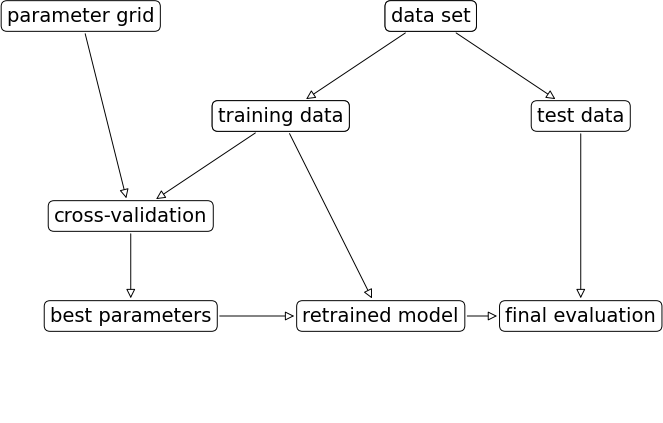

In [50]:
mglearn.plots.plot_grid_search_overview()

Because grid search with cross-validation is such a commonly used method to adjust
parameters, `scikit-learn` provides the `GridSearchCV` class, which implements it in
the form of an estimator. To use the GridSearchCV class, you first need to specify the
parameters you want to search over using a dictionary. `GridSearchCV` will then per‐
form all the necessary model fits. The keys of the dictionary are the names of parame‐
ters we want to adjust (as given when constructing the model—in this case, C and
gamma ), and the values are the parameter settings we want to try out.

In [53]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

print(f'parameter grid:\n{param_grid}')

# now we can instntiate GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid = param_grid, cv = 5)

# GridSearchCV will use cross-validation in place of the split into a training
# and validation set that we used before. However, we still need to split
# the data into a training and a test set, to avoid overfitting the parameters:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

# The grid_search object that we created behaves just like a
# classifier; we can call the standard methods fit , predict , and score on it.
grid_search.fit(X_train, y_train)

parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [54]:
print(f'test set score: {grid_search.score(X_test, y_test):.3f}')

test set score: 0.974


Choosing the parameters using cross-validation, we actually found a model that ach‐
ieves 97% accuracy on the test set. The important thing here is that we did not use the
test set to choose the parameters. The parameters that were found are scored in the
`best_params_` attribute, and the best cross-valdiation accuracy is stored in
`best_score_`

In [56]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


__Again, be careful not to confuse best_score_ with the generaliza‐
tion performance of the model as computed by the score method
on the test set. Using the score method (or evaluating the output of
the predict method) employs a model trained on the whole train‐
ing set. The best_score_ attribute stores the mean cross-validation
accuracy, with cross-validation performed on the training set.__

In [57]:
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Because `grid_search` itself has predict and score methods, using `best_estimator_`
is not needed to make predictions or evaluate the model.

### __Analyzing the result of cross-validation__